In [1]:
## fine tuning SAM

In [1]:
from mb_llm.segsam2 import DataProcessor,ModelTrainer

/home/malav/.local/lib/python3.11/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
data = DataProcessor.load_data('./example_data/full_path_data.csv')
data[0]

{'image': '/home/malav/Downloads/datasets/pp_dataset/data_to_test/images/0000.png',
 'annotation': '/home/malav/Downloads/datasets/pp_dataset/data_to_test/mask/0000_mask.png'}

In [3]:
model = ModelTrainer('/home/malav/Desktop/segment-anything-2/checkpoints/sam2_hiera_small.pt','./sam2_hiera_s.yaml',device='cpu')

In [4]:
model_updated = model.train(data,epochs=10,lr=0.0001,save_step=10,save_all=False)

/home/malav/.local/lib/python3.11/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Iteration 0, Segmentation Loss: 0.9954955577850342, Score Loss: 0.7144908308982849, Mean IOU: 0.0005113419517874718
Iteration 1, Segmentation Loss: 0.4028744697570801, Score Loss: 0.1700405478477478, Mean IOU: 0.005016760553792119
Iteration 2, Segmentation Loss: 1.8368974924087524, Score Loss: 0.2581098675727844, Mean IOU: 0.005197994384285063
Iteration 3, Segmentation Loss: 2.1810338497161865, Score Loss: 0.9035978317260742, Mean IOU: 0.00556316112318147
Iteration 4, Segmentation Loss: 0.11838623136281967, Score Loss: 0.3160756230354309, Mean IOU: 0.015426098242303964
Iteration 5, Segmentation Loss: 0.11404267698526382, Score Loss: 0.6487679481506348, Mean IOU: 0.02437670424138727
Iteration 6, Segmentation Loss: 0.1507493555545807, Score Loss: 0.6887997984886169, Mean IOU: 0.026776189214087226
Iteration 7, Segmentation Loss: 0.25357988476753235, Score Loss: 0.5465538501739502, Mean IOU: 0.02975382632020685
Iteration 8, Segmentation Loss: 0.5068294405937195, Score Loss: 0.3681003451347

In [ ]:
## testing model

import cv2
import pandas as pd
import numpy as np

t1 = pd.read_csv('./example_data/full_path_data.csv')

array([ 327.,  282., 1308.,  958.], dtype=float32)

In [37]:
row_val = 166
image = cv2.imread(t1['image_path'].iloc[row_val])
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
bbox = eval((t1['food_bbox'].iloc[row_val]))
bbox_np = np.array(bbox,dtype=np.float32)
bbox_np

array([ 253.,  246., 1297., 1077.], dtype=float32)

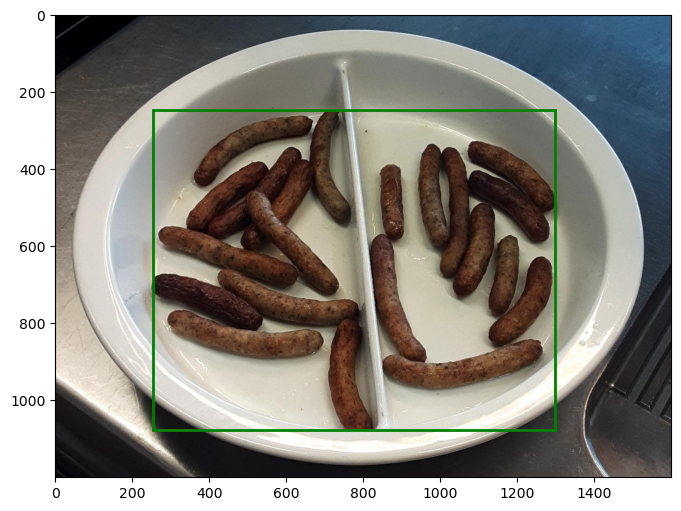

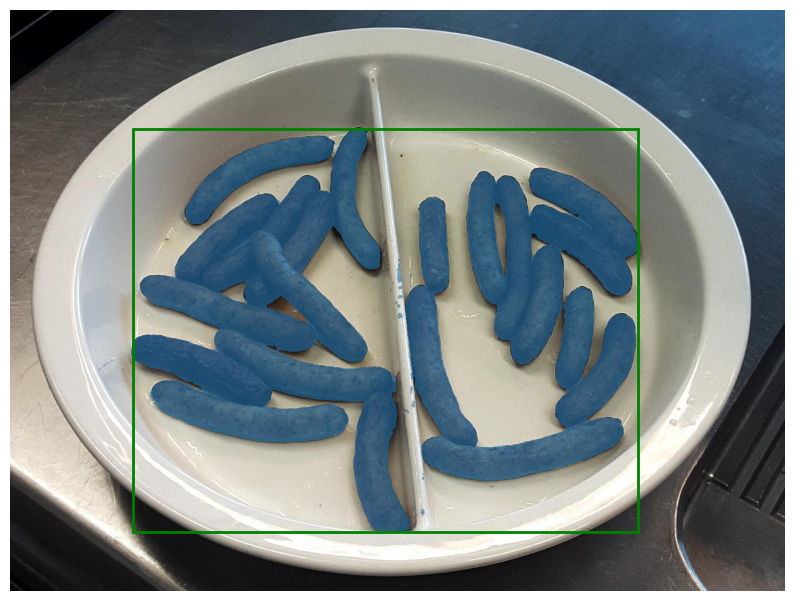

In [38]:
import matplotlib.pyplot as plt
import torch
from mb_llm.segsam2 import SAM2Processor

with torch.no_grad():
        model_updated.set_image(image)
        masks, scores, logits = model_updated.predict(
            box=bbox_np,multimask_output=False)
        
        sorted_ind = np.argsort(scores)[::-1]
        masks = masks[sorted_ind]
        scores = scores[sorted_ind]
        logits = logits[sorted_ind]

        plt.figure(figsize=(9, 6))
        plt.imshow(image)

        if bbox is not None:
            SAM2Processor.show_box(bbox, plt.gca())

        SAM2Processor.show_masks_image(image, masks, scores, box_coords=bbox)


In [ ]:
## orignial model test

import matplotlib.pyplot as plt
import torch
from mb_llm.segsam2 import SAM2Processor

with torch.no_grad():
        model_updated.set_image(image)
        masks, scores, logits = model_updated.predict(
            box=bbox_np,multimask_output=False)
        
        sorted_ind = np.argsort(scores)[::-1]
        masks = masks[sorted_ind]
        scores = scores[sorted_ind]
        logits = logits[sorted_ind]

        plt.figure(figsize=(9, 6))
        plt.imshow(image)

        if bbox is not None:
            SAM2Processor.show_box(bbox, plt.gca())

        SAM2Processor.show_masks_image(image, masks, scores, box_coords=bbox)

In [ ]:
from mb_llm.segsam2 import ImagePredictor
img_processor = ImagePredictor('./sam2_hiera_s.yaml','/home/malav/Desktop/segment-anything-2/checkpoints/sam2_hiera_small.pt')

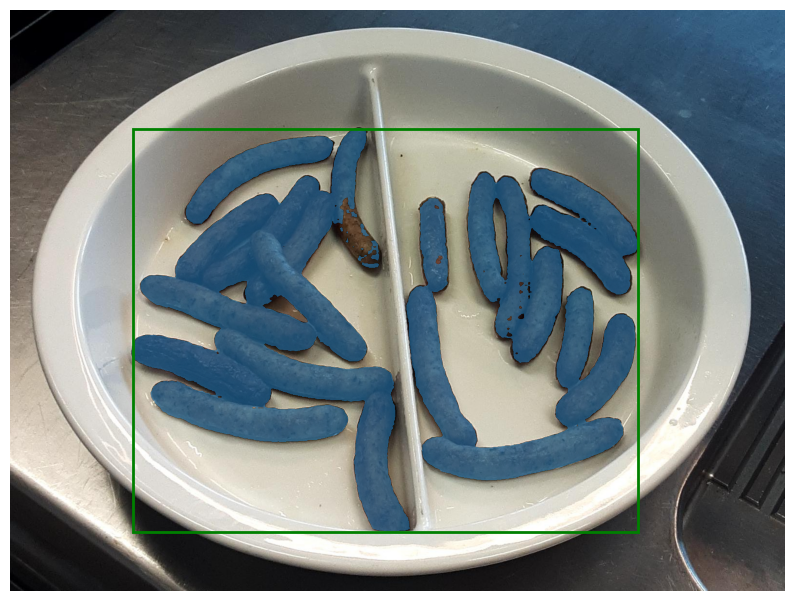

(array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32),
 array([0.78030413], dtype=float32),
 array([[[ -9.281283 , -10.798257 ,  -9.645952 , ..., -12.153431 ,
          -10.981319 , -12.361226 ],
         [-11.014004 ,  -9.044032 , -11.2293215, ..., -10.412189 ,
          -12.1451435, -11.17287  ],
         [ -9.49154  , -11.563937 , -10.381175 , ..., -12.15238  ,
          -10.899781 , -12.099526 ],
         ...,
         [-10.901603 ,  -9.611964 , -10.253322 , ..., -11.1708975,
          -13.9779215, -11.041818 ],
         [ -9.271348 , -11.264862 ,  -9.769782 , ..., -12.774632 ,
          -11.224582 , -11.889089 ],
         [-10.384371 ,  -8.849383 , -10.519865 , ..., -10.343815 ,
          -12.491321 , -11.179793 ]]], dtype=float32))

In [39]:
img_processor.set_image(t1['image_path'].iloc[row_val])
img_processor.predict_item(bbox=bbox_np,gemini_bbox=False) ## RETURNS : MASKS, SCORES, LOGITS
